•	ECONML environment note
•	If you want to run EconML's LinearDML in a stable environment, create a fresh conda env with compatible NumPy/Numba versions:
•	conda create -n econml python=3.10 numpy=2.3 numba=0.57 -c conda-forge
•	conda activate econml
•	pip install econml scikit-learn
•	Then run the notebook in that env or point the kernel at that interpreter.
•	Alternatively, keep using the sklearn DML-style fallback implemented in `causal.py`.


In [2]:
import sys
from pathlib import Path
project_root = Path("..").resolve()
src = project_root / "src"
sys.path.insert(0, str(src))
print("Added to sys.path:", src)
# verify import
import importlib, pkgutil
print('sales_attribution available:', pkgutil.find_loader('sales_attribution') is not None)

Added to sys.path: D:\Projects\Sales_Attribution\src
sales_attribution available: True


In [6]:
# Install necessary packages via pip if missing
import sys
import subprocess
import importlib

def pip_install(pkg):
    try:
        importlib.import_module(pkg)
        print(f"{pkg} already installed")
    except Exception:
        print(f"Installing {pkg}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

for p in ['pymc', 'arviz', 'econml']:
    pip_install(p)

print('Install steps done')

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


pymc already installed
arviz already installed
Installing econml...
Install steps done


In [11]:
# Check that installed packages are importable in this kernel
import importlib
for pkg in ('econml', 'pymc', 'arviz'):
    try:
        m = importlib.import_module(pkg)
        print(pkg, 'imported, version', getattr(m, '__version__', 'unknown'))
    except Exception as e:
        print(pkg, 'import failed:', e)


econml imported, version 0.16.0
pymc imported, version 5.23.0
arviz imported, version 0.22.0


In [13]:
# Test econml LinearDML import directly
try:
    from econml.dml import LinearDML
    print('LinearDML import OK')
except Exception as e:
    print('LinearDML import failed:', e)


LinearDML import failed: Numba needs NumPy 2.3 or less. Got NumPy 2.4.


In [15]:
# Reload our attribution modules to pick up newly available libs and code changes
import importlib
from sales_attribution.attribution import markov as _markov, bayesian_mmm as _bayes, causal as _causal
importlib.reload(_markov)
importlib.reload(_bayes)
importlib.reload(_causal)
print('Reloaded modules. PyMC available in bayes:', getattr(_bayes, 'HAS_PYMC', None))
print('EconML import in causal module will be attempted on demand.')

Reloaded modules. PyMC available in bayes: True
EconML import in causal module will be attempted on demand.


In [ ]:
# Reload bayesian_mmm to pick up changes and do a short test call
import importlib
import sales_attribution.attribution.bayesian_mmm as _bm
importlib.reload(_bm)
print('HAS_PYMC:', getattr(_bm, 'HAS_PYMC', None))
res = _bm.fit_bayesian_mmm(ts, draws=10, tune=10, fixed_decay=0.6)
print('Returned length:', (len(res) if hasattr(res, '__len__' ) else 'no_len'), 'types:', [type(x) for x in res])

In [23]:
from sales_attribution import data
from sales_attribution.attribution import rule_based, markov, causal, bayesian_mmm
import matplotlib.pyplot as plt, seaborn as sns
import pandas as pd

journeys = data.generate_user_journeys()
print('Journeys sample:')
print(journeys.head())

last = rule_based.last_touch_attribution(journeys)
first = rule_based.first_touch_attribution(journeys)
linear = rule_based.linear_attribution(journeys)

mr = markov.removal_effect(journeys)
inc = causal.estimate_incrementality_econml(journeys)

ts = data.generate_aggregate_timeseries()
trace, summary, ppc = None, None, None
try:
    # increased sampling for more reliable posterior estimates (can take a few minutes)
    trace, summary, ppc = bayesian_mmm.fit_bayesian_mmm(ts, draws=1000, tune=1000, fixed_decay=0.6)
except Exception as e:
    print('Bayesian fit skipped:', e)
    trace, summary, ppc = None, None, None

comp = []
for ch in sorted(set(journeys['channel'])):
    comp.append({'channel': ch, 'last': last.get(ch,0), 'first': first.get(ch,0), 'linear': linear.get(ch,0), 'markov_lost': mr.get(ch,{}).get('lost_conv',None), 'incremental': inc.get(ch,None)})
comp = pd.DataFrame(comp).set_index('channel')
print(comp)

Journeys sample:
   user_id  step      channel  converted
0        0     1      organic          0
1        1     1  paid_search          0
2        1     2        email          0
3        1     3       social          0
4        1     4      display          0
EconML not available or failed to import (numba/numpy conflict). Falling back to scikit-learn DML-style estimator.


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, intercept, beta]


c:\Users\31649\anaconda3\envs\table2text\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

c:\Users\31649\anaconda3\envs\table2text\Lib\site-packages\pymc\step_methods\hmc\quadpotential.py:316: 
RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)

c:\Users\31649\anaconda3\envs\table2text\Lib\site-packages\pytensor\scalar\basic.py:3191: RuntimeWarning: overflow 
encountered in exp
  return np.exp(x)

c:\Users\31649\anaconda3\envs\table2text\Lib\site-packages\numpy\_core\fromnumeric.py:83: RuntimeWarning: invalid 
value encountered in reduce
  else:

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 199 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Bayesian fit skipped: not enough values to unpack (expected 3, got 2)
             last  first      linear   markov_lost  incremental
channel                                                        
display       206    203  200.016667 -1.110223e-16    59.490568
email         216    206  204.116667 -1.110223e-16    70.984534
organic       509    506  507.083333 -2.220446e-16   466.406151
paid_search   458    493  479.066667 -2.220446e-16   524.814277
social        187    168  185.716667 -1.110223e-16    31.426721


In [21]:
# Controlled experiment to validate detection power
from sales_attribution import data_controlled
# create strong effects for paid_search and organic
effects = {'paid_search': 0.05, 'organic': 0.04}
ctrl_journeys = data_controlled.generate_controlled_journeys(n_users=20000, channel_effects=effects, max_steps=6, seed=123)
print('Controlled journeys sample:')
print(ctrl_journeys.head())

# Run attribution methods on controlled journeys
last_c = rule_based.last_touch_attribution(ctrl_journeys)
first_c = rule_based.first_touch_attribution(ctrl_journeys)
linear_c = rule_based.linear_attribution(ctrl_journeys)
mr_c = markov.removal_effect(ctrl_journeys)
inc_c = causal.estimate_incrementality_econml(ctrl_journeys)

rows = []
channels = sorted(set(ctrl_journeys['channel']))
for ch in channels:
    rows.append({'channel': ch, 'last': last_c.get(ch,0), 'first': first_c.get(ch,0), 'linear': linear_c.get(ch,0), 'markov_lost': mr_c.get(ch,{}).get('lost_conv',None), 'incremental': inc_c.get(ch,None)})
comp_ctrl = pd.DataFrame(rows).set_index('channel')
print('\nControlled experiment comparison:')
print(comp_ctrl)

# Save controlled comparison
comp_ctrl.to_csv(out / 'comparison_controlled.csv')

Controlled journeys sample:
   user_id  step  channel  converted
0        0     1    email          0
1        1     1  organic          0
2        1     2  organic          0
3        1     3  display          0
4        1     4   social          0
EconML not available or failed to import (numba/numpy conflict). Falling back to scikit-learn DML-style estimator.

Controlled experiment comparison:
             last  first      linear   markov_lost  incremental
channel                                                        
display       193    218  209.166667  2.220446e-16   -53.197290
email         191    220  215.050000  1.110223e-16    -6.275179
organic       682    689  675.183333 -4.440892e-16   882.526425
paid_search   625    575  596.200000 -2.220446e-16   837.667507
social        216    205  211.400000  0.000000e+00    19.850145


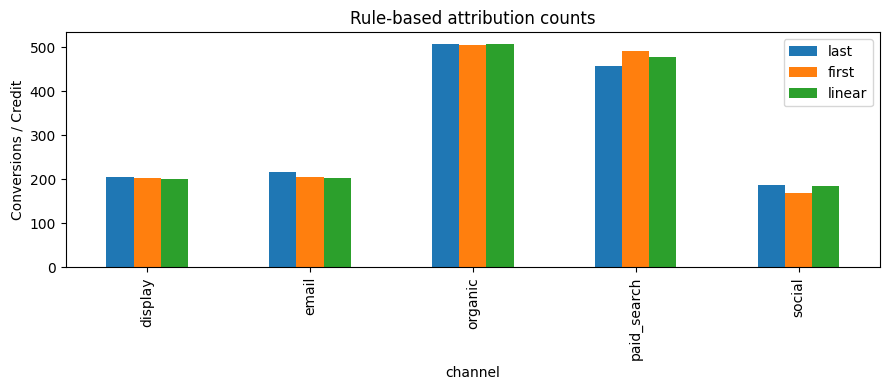

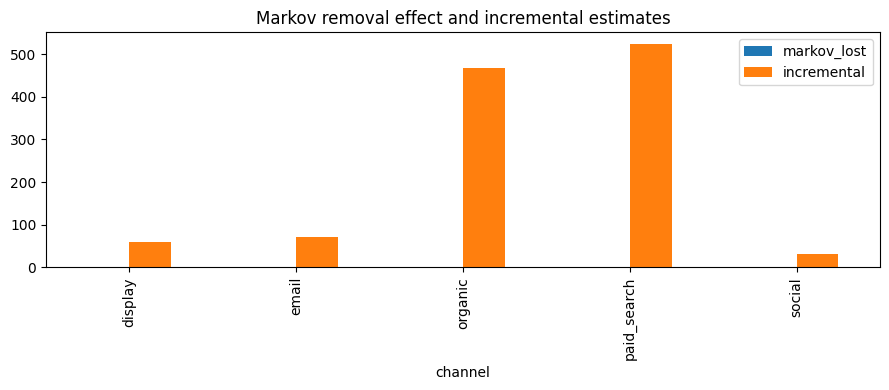


Bayesian MMM summary:
Bayesian diagnostics skipped: 'var names: "[\'decay\'] are not present" in dataset'
Saved outputs to D:\Projects\Sales_Attribution\notebooks\outputs


In [ ]:
from pathlib import Path
out = Path('outputs')
out.mkdir(exist_ok=True)

# Rule-based comparison
ax = comp[['last','first','linear']].plot(kind='bar', figsize=(9,4))
ax.set_title('Rule-based attribution counts')
ax.set_ylabel('Conversions / Credit')
plt.tight_layout()
plt.savefig(out / 'rule_based.png', dpi=150)
plt.show()

# Markov & Incremental
fig, ax = plt.subplots(figsize=(9,4))
comp[['markov_lost','incremental']].fillna(0).plot(kind='bar', ax=ax)
ax.set_title('Markov removal effect and incremental estimates')
plt.tight_layout()
plt.savefig(out / 'markov_incremental.png', dpi=150)
plt.show()

# Bayesian posterior diagnostics (if available)
if 'trace' in globals() and trace is not None:
    try:
        import arviz as az
        print('\nBayesian MMM summary:')
        # handle our summary being a dict (when HAS_ARVIZ=True we return a dict with 'arviz_summary' and 'beta_table')
        if isinstance(summary, dict) and 'arviz_summary' in summary:
            print(summary['arviz_summary'])
            btab = summary['beta_table']
            fig, ax = plt.subplots(figsize=(8,4))
            ax.bar(btab.index, btab['beta_orig_mean'].values)
            ax.set_title('Bayesian MMM posterior mean betas (original scale)')
            plt.tight_layout()
            plt.savefig(out / 'bayes_beta.png', dpi=150)
            plt.show()
        else:
            try:
                s = az.summary(trace, var_names=['intercept','beta'])
                print(s)
                az.plot_trace(trace, var_names=['beta'])
                plt.tight_layout()
                plt.savefig(out / 'bayes_trace.png', dpi=150)
                plt.show()
                # posterior mean betas
                s2 = az.summary(trace, var_names=['beta'])
                beta_means = [s2.loc[name, 'mean'] for name in s2.index]
                chs = [c.replace('spend_','') for c in ts.columns if c.startswith('spend_')]
                fig, ax = plt.subplots(figsize=(8,4))
                ax.bar(chs, beta_means)
                ax.set_title('Bayesian MMM posterior mean betas (standardized scale)')
                plt.tight_layout()
                plt.savefig(out / 'bayes_beta.png', dpi=150)
                plt.show()
            except Exception as e:
                print('Could not summarize with ArviZ:', e)

        # Posterior predictive checks
        try:
            if ppc is not None and 'obs' in ppc:
                samples = ppc['obs']
                pp_mean = samples.mean(axis=0)
                q_low = np.percentile(samples, 5, axis=0)
                q_high = np.percentile(samples, 95, axis=0)
                fig, ax = plt.subplots(figsize=(10,4))
                ax.plot(ts.index, ts['conversions'].values, label='observed')
                ax.plot(ts.index, pp_mean, label='ppc mean')
                ax.fill_between(ts.index, q_low, q_high, color='gray', alpha=0.3, label='5-95%')
                ax.set_title('Posterior predictive vs observed')
                ax.legend()
                plt.tight_layout()
                plt.savefig(out / 'bayes_ppc.png', dpi=150)
                plt.show()
            else:
                print('No posterior predictive samples available to plot')
        except Exception as e:
            print('PP check skipped:', e)

    except Exception as e:
        print('Bayesian diagnostics skipped:', e)

# Save comparison table
comp.to_csv(out / 'comparison_table.csv')
print('Saved outputs to', out.resolve())

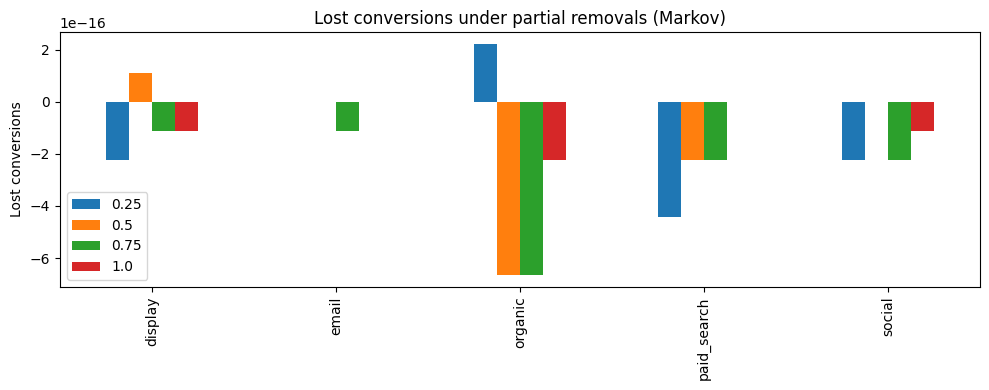

                     0.25          0.50          0.75          1.00
display     -2.220446e-16  1.110223e-16 -1.110223e-16 -1.110223e-16
email        0.000000e+00  0.000000e+00 -1.110223e-16  0.000000e+00
organic      2.220446e-16 -6.661338e-16 -6.661338e-16 -2.220446e-16
paid_search -4.440892e-16 -2.220446e-16 -2.220446e-16  0.000000e+00
social      -2.220446e-16  0.000000e+00 -2.220446e-16 -1.110223e-16


In [20]:
# Reload markov module to pick up new function
import importlib
import sales_attribution.attribution.markov as markov
importlib.reload(markov)

# Markov partial removal experiments
fractions = [0.25, 0.5, 0.75, 1.0]
res = {}
for f in fractions:
    r = markov.removal_effect_fraction(journeys, fraction=f)
    res[f] = {ch: r[ch]['lost_conv'] for ch in r}
res_df = pd.DataFrame(res)
ax = res_df.plot(kind='bar', figsize=(10,4))
ax.set_title('Lost conversions under partial removals (Markov)')
ax.set_ylabel('Lost conversions')
plt.tight_layout()
plt.savefig(out / 'markov_partial_removal.png', dpi=150)
plt.show()

# Show table
print(res_df)
res_df.to_csv(out / 'markov_partial_removal.csv')